# Zarr Database Summary & Validation

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

from satip import io

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import FEAutils as hlp
from warnings import warn
from ipypb import track

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23rows/s]


<br>

### User Inputs

We have to specify the bucket where the data is located

In [2]:
zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/zarr_full_extent_TM_int16'

<br>

### Data Loading & Coverage

The `satip` wrapper for loading data will then generate an `xarray` `Dataset` when passed the path to the zarr bucket

In [8]:
ds = io.load_from_zarr_bucket(zarr_bucket)

ds['stacked_eumetsat_data']

,Array,Chunk
Bytes,957.51 GB,246.53 MB
Shape,"(11652, 1870, 1831, 12)","(36, 1870, 1831, 1)"
Count,3889 Tasks,3888 Chunks
Type,int16,numpy.ndarray


<br>

We'll quickly visualise the data coverage that's provided in the database.

N.b. Here we've made the assumption that an image is generated every 5 minutes.

The database coverage is currently at 5.0%


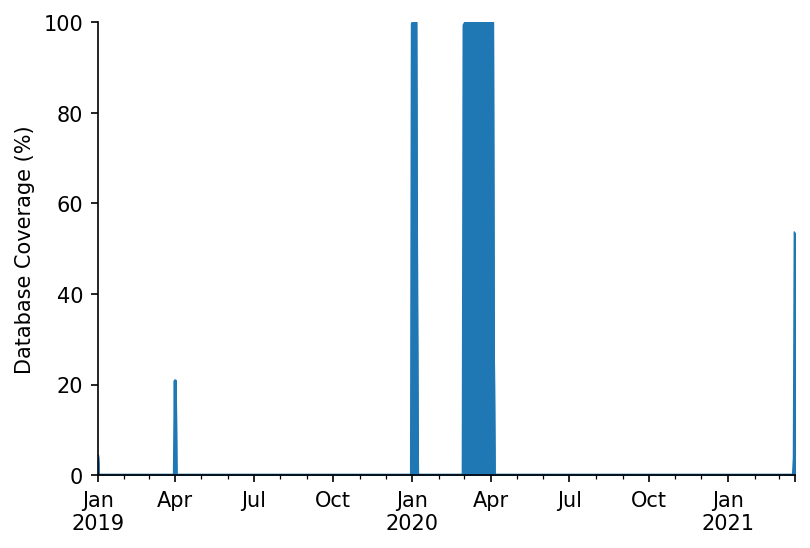

In [4]:
round_dt_idx = lambda dt_idx: pd.to_datetime(((dt_idx.astype(np.int64) // ns5min + 1 ) * ns5min))

ns5min = 5*60*1000000000

zarr_db_dts = pd.to_datetime(ds['stacked_eumetsat_data'].time.values)
dt_rng_5m = round_dt_idx(pd.date_range(zarr_db_dts.min(), zarr_db_dts.max(), freq='5T'))

s_db_coverage = pd.Series(round_dt_idx(zarr_db_dts)).value_counts().reindex(dt_rng_5m)
current_db_coverage = 1 - s_db_coverage.isnull().mean()

print(f'The database coverage is currently at {100*current_db_coverage:.1f}%')

# Plotting
fig, ax = plt.subplots(dpi=150)

s_db_coverage.resample('D').sum().pipe(lambda s: 100*s/s.max()).plot.area(ax=ax)

ax.set_ylim(0, 100)
ax.set_ylabel('Database Coverage (%)')
hlp.hide_spines(ax)

<br>

We'll create a slightly modified version of this that doesn't show percentage coverage for each day but instead considers each 5 minute period and groups batches of data that were retrieved sequentially 

In [5]:
#exports
def extract_dt_batch_sets(zarr_db_dts):
    dt_rng_split_idxs = (pd.Series(zarr_db_dts).diff(1).dt.total_seconds().abs() > (5 * 60 * 2)).replace(False, np.nan).dropna().index

    dt_batch_start_idxs = [0] + list(dt_rng_split_idxs)
    dt_batch_end_idxs = list(dt_rng_split_idxs-1) + [len(zarr_db_dts)-1]

    dt_batches = []

    for dt_batch_start_idx, dt_batch_end_idx in zip(dt_batch_start_idxs, dt_batch_end_idxs):
        dt_batches += [(zarr_db_dts[dt_batch_start_idx], zarr_db_dts[dt_batch_end_idx])]
        
    return dt_batches

 [████████████████████████████████████████████████████████████] 62/62 [06:28<00:10, 6.26s/it]

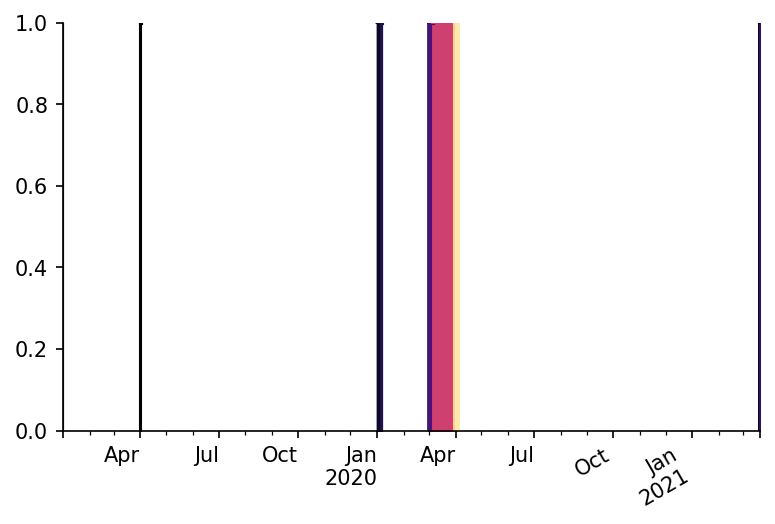

In [7]:
dt_batches = extract_dt_batch_sets(zarr_db_dts)

# Plotting
fig, ax = plt.subplots(dpi=150)

cmap = mpl.cm.get_cmap('magma')
total_dts_processed = 0

for batch_start_dt, batch_end_dt in track(dt_batches):
    if batch_start_dt == batch_end_dt:
        s_db_batch = pd.Series([1, 1], index=[batch_start_dt, batch_start_dt+pd.Timedelta(minutes=5)])
        total_dts_processed += 1
        batch_mid_pct_processed = total_dts_processed/zarr_db_dts.size
    else:
        s_db_batch = s_db_coverage[batch_start_dt:batch_end_dt]
        total_dts_processed += s_db_batch.size
        batch_mid_pct_processed = (total_dts_processed-(s_db_batch.size/2))/zarr_db_dts.size
        
    color = cmap(batch_mid_pct_processed)
    s_db_batch.plot.area(color=color, ax=ax)
    
ax.set_xlim(zarr_db_dts.min(), zarr_db_dts.max())
ax.set_ylim(0, 1)
hlp.hide_spines(ax)

<br>

### Summary Statistics

We'll start by calculating the average reflectance for a single month to check that no dodgy regions jump out. Interestly we can see mountainous regions such as the Alps jump out due to the high reflectance of snow.

<ipython-input-16-455a547b74f1>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())


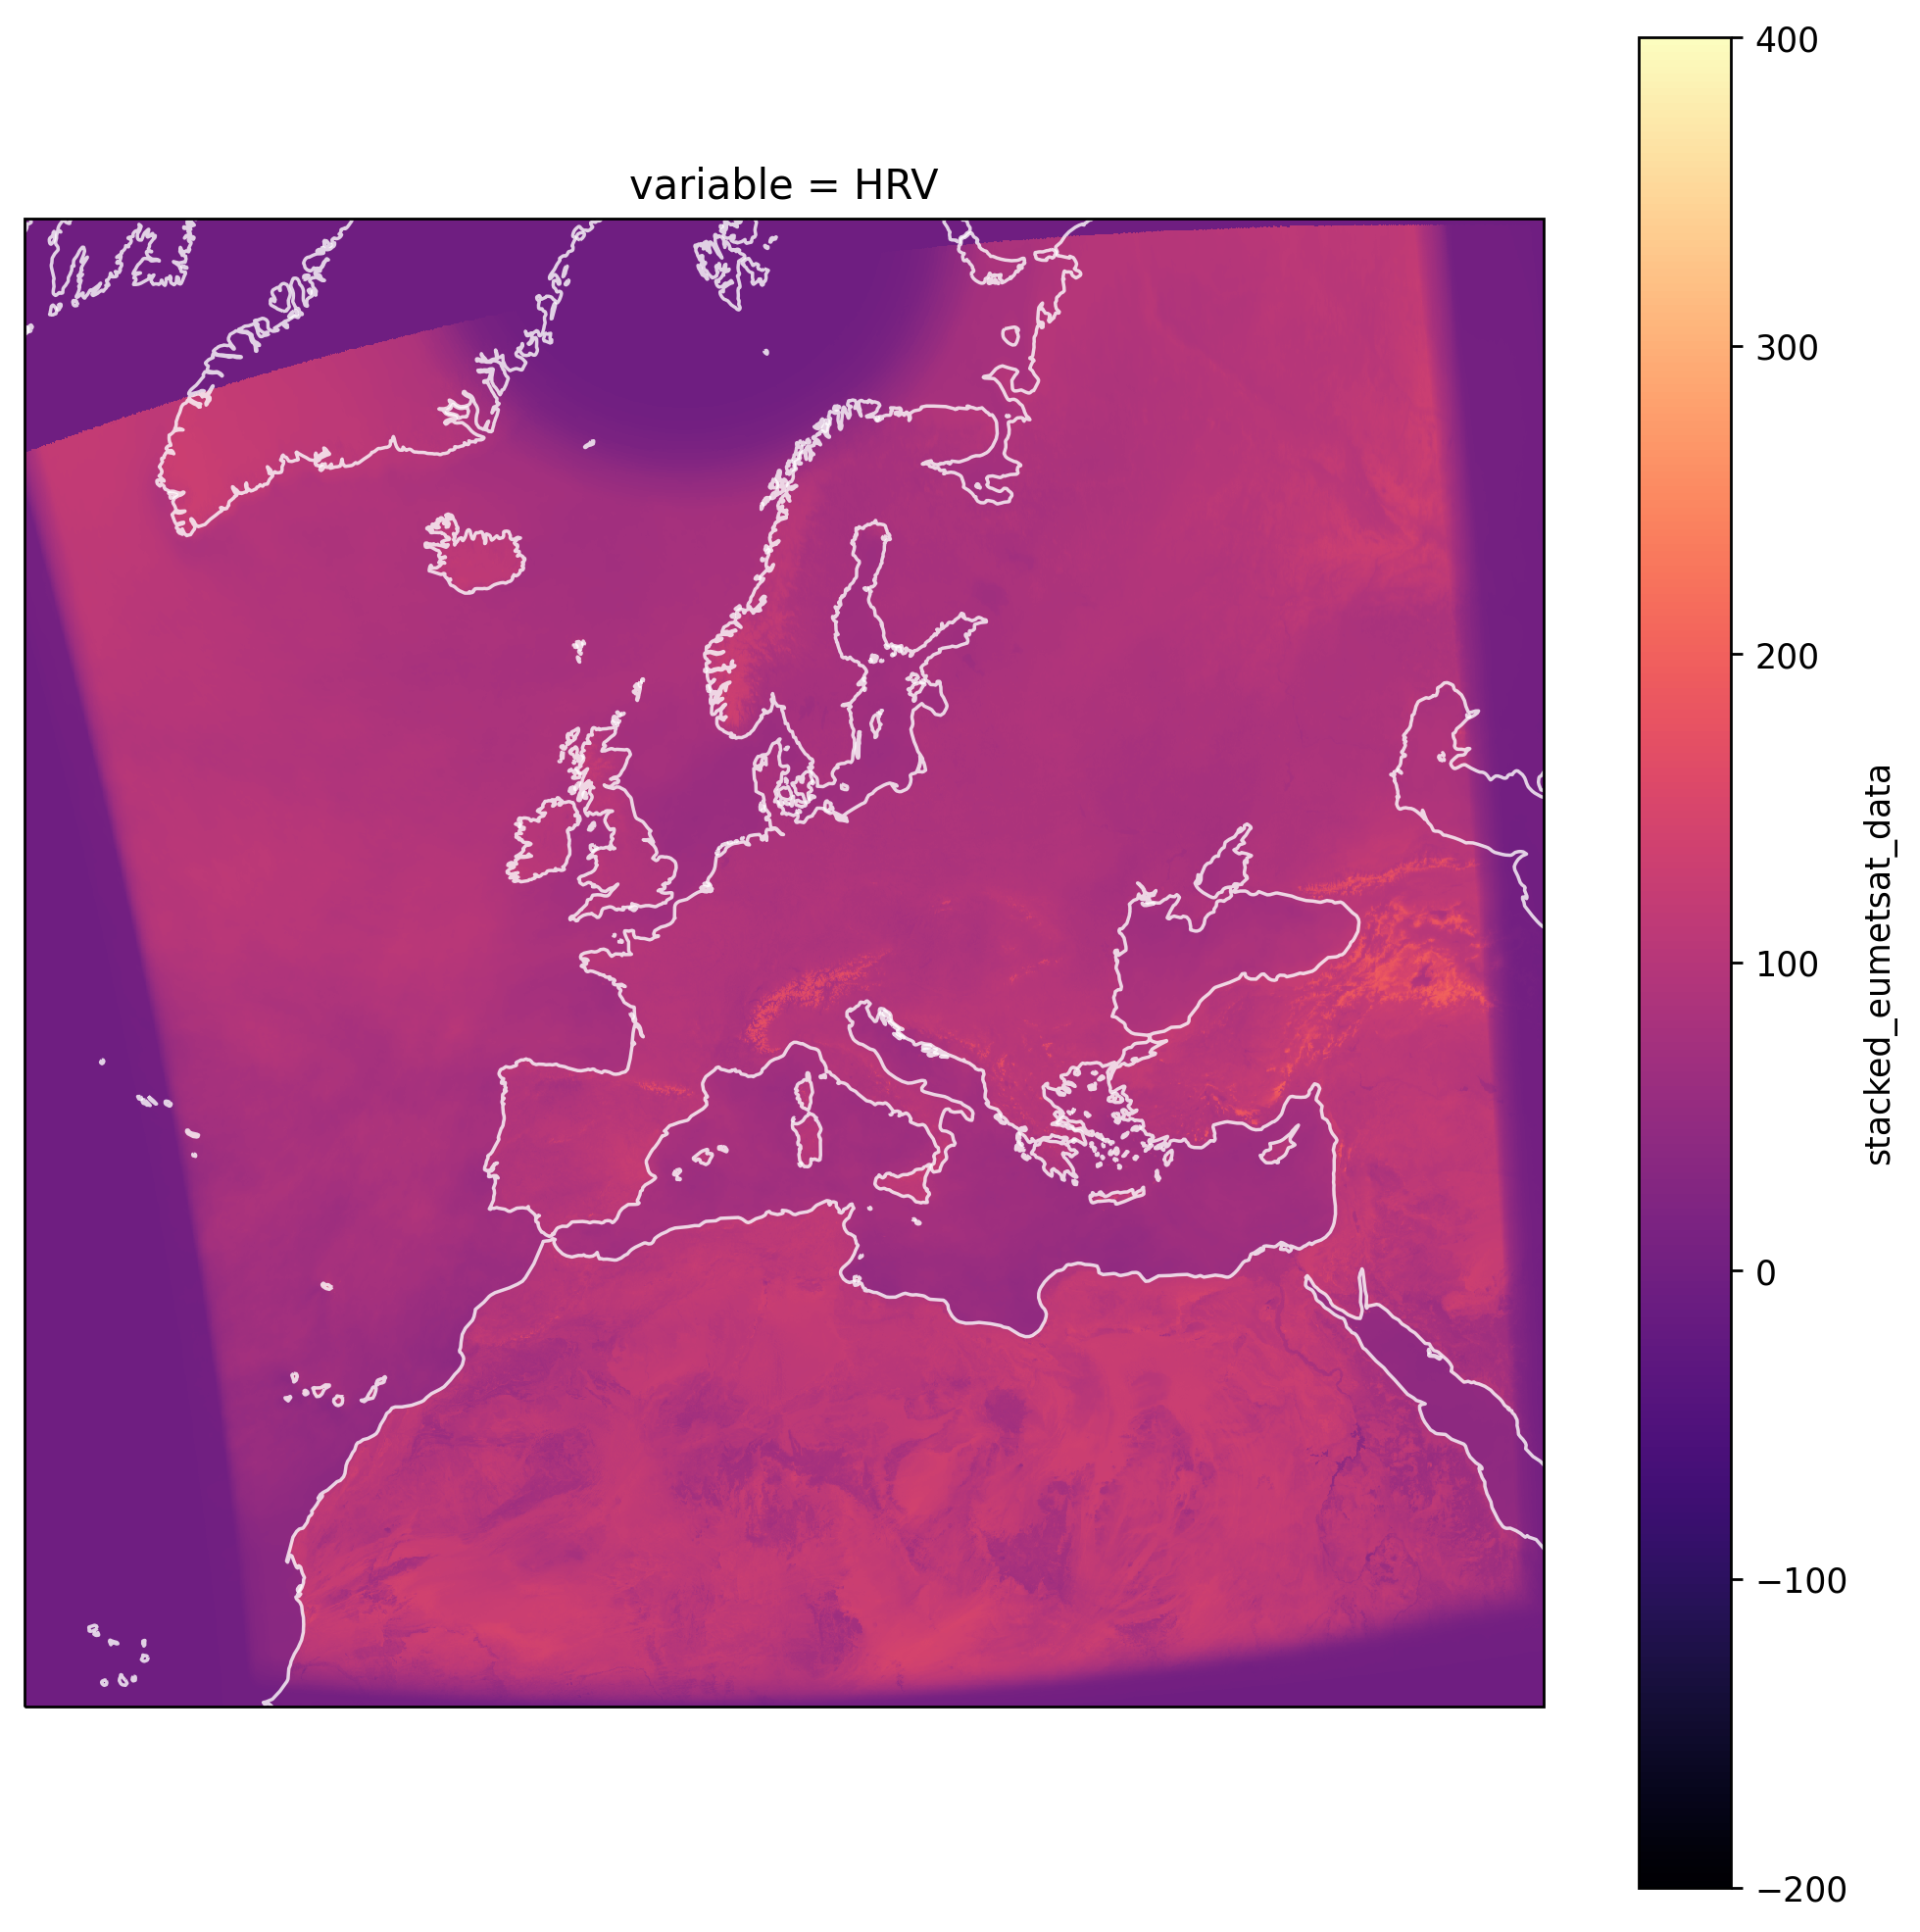

In [16]:
%%time # takes ca.18 mins

da_HRV_mean = (ds
               ['stacked_eumetsat_data']
               .sel(variable='HRV', time='2020-03')
               .mean(dim='time')
              )

# Plotting
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

da_HRV_mean.T.plot.imshow(ax=ax, cmap='magma', vmin=-200, vmax=400)

ax.coastlines(resolution='50m', alpha=0.8, color='white')

<br>

We'll also look at how the average reflectance changes with time of day

In [ ]:
%%time
# if this fails take avg of x and y, then convert to df and process with pandas
da_HRV_hourly_mean = (ds
                      ['stacked_eumetsat_data']
                      .sel(variable='HRV', time='2020-03')
                      .groupby('time.dt.hour')
                      .mean(dim=['x', 'y'])
                      .compute()
                     )

da_HRV_hourly_mean.plot()

<br>

We'll also get the minimum and maximum values present for each variable

In [41]:
#exports
def get_var_min_maxs(ds):
    mins = ds['stacked_eumetsat_data'].sel(time='2020-03').min(['time', 'x', 'y']).compute()
    maxs = ds['stacked_eumetsat_data'].sel(time='2020-03').max(['time', 'x', 'y']).compute()
    
    return mins, maxs

In [ ]:
mins, maxs = get_var_min_maxs(ds)

mins, maxs

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<br>

### Offline Validation

We'll now do some quick data quality checks, including checking for duplicates and any null values. We'll start with the duplicates.

In [19]:
#exports
def check_for_duplicates(ds):
    ds_dts = pd.to_datetime(ds.time.values)
    num_dupes = ds_dts.duplicated().sum()
    
    assert num_dupes == 0, f'There are {num_dupes} duplicate indexes in the database'
    
    return 

In [20]:
check_for_duplicates(ds)

<br>

Then check for any nulls.

In [ ]:
#exports
get_null_count = lambda ds: (ds==-1).sum()

In [ ]:
%%time

get_null_count(ds)